# Demo RNN -- AI二次創作

程式碼參考: [Tensorflow](https://www.tensorflow.org/tutorials/text/text_generation)

**請勿將本次資料集散播、更改、用於非商業用途**。

> **訓練步驟**

深度學習在訓練模型上有以下幾個重要的步驟:
1. 讀入相關封包
2. 取得資料集 
3. 資料前處理
4. 建立模型
5. 制定訓練計畫
6. 評估模型
7. 做預測

> **本次模型介紹 RNN**

![](https://i.imgur.com/FaY50C8.png)


我們來看看維度，很多人會搞不懂RNN的維度:

一個Seq通過RNN後的維度

* Input: (Seq,${originDim}$)
* RNN Neuron: 2048
* Output: (Seq,2048) if (return_sequence == True) else (1,2048)

![](https://i.imgur.com/9SVl6JR.png)

![](https://i.imgur.com/z4ElFIr.png)

> **把生成問題變成分類問題**

![](https://i.imgur.com/TBHKuf6.png)


In [ ]:
# ****************************************
# **請勿將本次資料集散播、用於非學術用途**
# ****************************************

!gdown --id 1HvuKZLAmenzqAoyAcYVf0VFKmasl0tN5 --output "./Animal farm.txt"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1HvuKZLAmenzqAoyAcYVf0VFKmasl0tN5
To: /content/Animal farm.txt
100% 163k/163k [00:00<00:00, 77.7MB/s]


## 1. 讀入Package

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

## 2. 取得資料集

In [ ]:
book = ""
with open("./Animal farm.txt","r",encoding="utf8") as file:
  for line in file:
    book += line

book_length = len(book)
unique_words = set(book)
print(f"Animal farm共有 {book_length} 字詞")
print(f"包含了 {len(unique_words)} 個獨一無二的字 (含標點符號)\n")
print(book[0:500])

Animal farm共有 55564 字詞
包含了 2377 個獨一無二的字 (含標點符號)


《二○一六年七月一日版》
《好讀書櫃》典藏版
作者介紹
英國作家喬治•歐威爾原名艾瑞克•亞瑟•布萊爾（Eric Arthur Blair），除了小說，也寫紀實及評論性質的散文，一九四○年代末期因兩部諷諭傑作《動物農莊》（Animal Farm：A Fairy Story）與《一九八四》（Nineteen Eighty─Four）聲名大噪，躍身為二十世紀最重要也最具影響力的文豪之一。
※※※
〈反抗的名字如此誕生〉
一九○三年，歐威爾生於印度的一座村莊蒙地哈里（Motihari），當時的印度為英國殖民地，歐威爾的父親任職於印度總督府鴉片局（Opium Department of the Indian Civil Service），家境稱不上富裕，一如當時許多中產階級英國家庭，身無恆產，生計及前景完全仰賴帝國政府。歐威爾日後自嘲為「中產階級下層分子」（lower─upper─middle class）。一九○七年，歐威爾隨母親回到英國，父親留在印度工作直至一九二一年退休為止。
在一九四七年發表的〈我為何寫作〉（「Why I Write」）一文中，歐威爾自述早在五、六歲的年紀便有心成為作家


## 3. 資料前處理

文字前處理有一堆方法、作法:
* 切字
* 還原
* 清除特殊字符
* 清除不常見字符 (StopWord)


我這裡僅使用去除不常見的字(StopWord)

In [ ]:
# 計算字數統計
words_count = {}
for w in book:
  if w in words_count:
    words_count[w] += 1
  else:
    words_count[w] = 1

words_count = sorted(words_count.items(),key=lambda x:x[1])

In [ ]:
stop_word = 8
unique_words = [w_tup[0] for w_tup in words_count if w_tup[1]>stop_word]
print(f"去除次數小於{stop_word}的文字剩餘 : {len(unique_words)}")

去除次數小於8的文字剩餘 : 891


In [ ]:
print(f"原本Animal farm共有 {book_length} 字詞")
print(f"去除不常出現的文字後")
book = [w for w in book if w in unique_words]
print(f"剩餘{len(book)}個字")

原本Animal farm共有 55564 字詞
去除不常出現的文字後
剩餘50958個字


In [ ]:
# 文字轉數字(index)
word_2_index = {word:index for index,word in enumerate(unique_words)}
index_2_word = {word_2_index[word]:word for word in word_2_index}

book_2_index = [word_2_index[w] for w in book]

print("原始文字 : ")
print(book[:40])
print("-"*40)
print("轉成index : ")
print({word_2_index[w] for w in book[:40]})

原始文字 : 
['\n', '《', '二', '○', '一', '六', '年', '七', '月', '一', '日', '版', '》', '\n', '《', '好', '讀', '書', '》', '版', '\n', '作', '者', '\n', '英', '國', '作', '家', '治', '•', '歐', '威', '爾', '原', '名', '克', '•', '•', '布', '爾']
----------------------------------------
轉成index : 
{771, 654, 782, 655, 662, 540, 798, 293, 550, 681, 429, 818, 696, 569, 830, 831, 835, 579, 603, 477, 98, 99, 877, 365, 626, 499, 627, 628, 887}


In [ ]:
def ind2word_seq(seq):
  return [index_2_word[i] for i in seq]

In [ ]:
# 設定輸入模型長度
seq_len = 20
characters = tf.data.Dataset.from_tensor_slices(book_2_index)
# characters = characters.map(lambda w:word_2_index[w.item()])

sequences = characters.batch(seq_len+1,drop_remainder=True)

for seq in sequences.take(2):
  print(seq.shape)
  print(seq)
  print([index_2_word[i] for i in seq.numpy()])

(21,)
tf.Tensor(
[877 626 603  98 887 499 818 540 569 887 696 654 627 877 626 798 365 681
 627 654 877], shape=(21,), dtype=int32)
['\n', '《', '二', '○', '一', '六', '年', '七', '月', '一', '日', '版', '》', '\n', '《', '好', '讀', '書', '》', '版', '\n']
(21,)
tf.Tensor(
[831 830 877 771 782 831 835 293 429 477 662 628 579 655  99 429 429 550
 628 765 772], shape=(21,), dtype=int32)
['作', '者', '\n', '英', '國', '作', '家', '治', '•', '歐', '威', '爾', '原', '名', '克', '•', '•', '布', '爾', '（', 'r']


![](https://i.imgur.com/YMVMFEJ.png)


In [ ]:
# 做input、target切割
def split_input_target(seq):
  input_txt = seq[:-1]
  target_txt = seq[1:]
  return input_txt,target_txt

split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

![](https://i.imgur.com/YoHWLkf.png)


In [ ]:
dataset = sequences.map(split_input_target)

for input_example,target_exaple in dataset.take(1):
  print("Input :", ind2word_seq(input_example.numpy()))
  print("Target:", ind2word_seq(target_exaple.numpy()))
  print("-"*50)
  print("Input :", input_example.numpy())
  print("Target:", target_exaple.numpy())

Input : ['\n', '《', '二', '○', '一', '六', '年', '七', '月', '一', '日', '版', '》', '\n', '《', '好', '讀', '書', '》', '版']
Target: ['《', '二', '○', '一', '六', '年', '七', '月', '一', '日', '版', '》', '\n', '《', '好', '讀', '書', '》', '版', '\n']
--------------------------------------------------
Input : [877 626 603  98 887 499 818 540 569 887 696 654 627 877 626 798 365 681
 627 654]
Target: [626 603  98 887 499 818 540 569 887 696 654 627 877 626 798 365 681 627
 654 877]


In [ ]:
# 建立資料集
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True))

dataset

<BatchDataset element_spec=(TensorSpec(shape=(64, 20), dtype=tf.int32, name=None), TensorSpec(shape=(64, 20), dtype=tf.int32, name=None))>

## 4. 建立模型

![](https://i.imgur.com/TBHKuf6.png)

In [ ]:
# 超參數
EMBEDDING_DIM = 512

# 使用 keras 建立一個非常簡單的 LSTM 模型
model = tf.keras.Sequential()

model.add(
  tf.keras.layers.Embedding(
    input_dim=len(unique_words), 
    output_dim=EMBEDDING_DIM
))

model.add(
  tf.keras.layers.LSTM(
    units=4096, 
    return_sequences=True, 
))

model.add(
  tf.keras.layers.LSTM(
    units=2048, 
    return_sequences=True,
))
  
model.add(
  tf.keras.layers.Dense(
      len(unique_words),activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 512)         456192    
                                                                 
 lstm (LSTM)                 (None, None, 4096)        75513856  
                                                                 
 lstm_1 (LSTM)               (None, None, 2048)        50339840  
                                                                 
 dense (Dense)               (None, None, 891)         1825659   
                                                                 
Total params: 128,135,547
Trainable params: 128,135,547
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 查看模型的輸入、輸出 shape
for input_example,target_exaple in dataset.take(1):
  predict_example = model(input_example)
  print(f"Model input shape : {input_example.shape}")
  print(f"Model output shape : {predict_example.shape}")
  print(f"Model target shape : {target_exaple.shape}")

Model input shape : (64, 20)
Model output shape : (64, 20, 891)
Model target shape : (64, 20)


In [ ]:
print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入尚未訓練的model後獲得：")
print()

predict_words = tf.math.argmax(predict_example[0],-1)
[print(index_2_word[ind],end="") for ind in predict_words.numpy()]
print()

原本的中文字序列：
存在且應該維下去的友。豬和人類之間沒有、
----------------------------------------
輸入尚未訓練的model後獲得：

結像形形無吧吧收收剛剛（內內八八八著著失


## 5. 制定訓練計畫並訓練

* [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) V.S. [categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy)

```python=
# categorical_crossentropy
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

# sparse_categorical_crossentropy
y_true = [1, 2]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

```


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam")

In [ ]:
EPOCHS = 20
history = model.fit(
    dataset, # 前面使用 tf.data 建構的資料集
    epochs=EPOCHS,
)

Epoch 1/20
37/37 [==============================] - 10s 158ms/step - loss: 6.3794
Epoch 2/20
37/37 [==============================] - 6s 158ms/step - loss: 6.0010
Epoch 3/20
37/37 [==============================] - 6s 157ms/step - loss: 5.8307
Epoch 4/20
37/37 [==============================] - 6s 157ms/step - loss: 5.5117
Epoch 5/20
37/37 [==============================] - 6s 157ms/step - loss: 5.2354
Epoch 6/20
37/37 [==============================] - 6s 157ms/step - loss: 5.0077
Epoch 7/20
37/37 [==============================] - 6s 157ms/step - loss: 4.7625
Epoch 8/20
37/37 [==============================] - 6s 157ms/step - loss: 4.5003
Epoch 9/20
37/37 [==============================] - 6s 158ms/step - loss: 4.1977
Epoch 10/20
37/37 [==============================] - 6s 158ms/step - loss: 3.8015
Epoch 11/20
37/37 [==============================] - 6s 158ms/step - loss: 3.3165
Epoch 12/20
37/37 [==============================] - 6s 159ms/step - loss: 2.7133
Epoch 13/20
37/37 [=====

## 6. 衡量模型

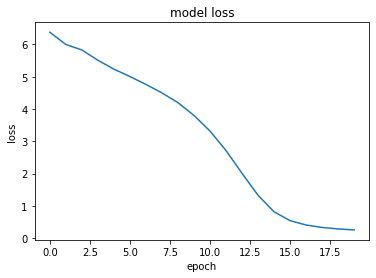

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
after_train_predictions = model(input_example)
after_sampled_indices = tf.argmax(after_train_predictions[0],1)

print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入進訓練後的model後獲得：")
print()

[print(index_2_word[ind],end="") for ind in after_sampled_indices.numpy()]
print()

原本的中文字序列：
存在且應該維下去的友。豬和人類之間沒有、
----------------------------------------
輸入進訓練後的model後獲得：

在且應該維下去的友。豬和人類之間沒有、也


## 7. 做預測

![](https://i.imgur.com/YsOj6Mw.png)

在實際生成文字時，我們會想要增加一些隨機性。比如”天天出去” 不加入隨機 “天天天天” 如果我們全部輸出的字都是取softmax最大可能性，則一個訓練完美的model會把整本書給輸出出來。但是我們要的是，希望電腦在最大可能性的幾個字中隨機挑選一個字出來。

tf.random.categorical 會根據softmax機率後隨機挑選字，但是我們不希望因為模型很爛導致不合理的字被選中，因此我們會除上一個temperature來增加可能字的比重。

EX: "天天出去" 預測下一個字
1. 玩 : 0.3 
2. 天 : 0.1 
3. 浪 : 0.4 

"天"有的機率被印出，我們不希望。所以我們可以在每一個機率除上一個temperature(0.01)
1. 玩 : 30 
2. 天 : 10 
3. 浪 : 40 
原本"浪"跟"天"差0.3，除temperature後差30



In [ ]:
# 預測文字，並把預測文字循環當作下一次的輸入

# 設定你的temperature
temperature = 0.01

def generateWords(input,words=500):
  [print(index_2_word[ind],end="") for ind in input]
  for i in range(words):
    next_input = tf.expand_dims(input,axis=0)
    predicts = model(next_input)
    predicts = predicts[:,-1,:]
    predicts /= temperature
    result = tf.random.categorical(
        predicts,num_samples=1
    )
    chinese_ind = tf.squeeze(result).numpy()
    print(index_2_word[chinese_ind],end="")
    input = input+[chinese_ind]
    input = input[-seq_len:]

In [ ]:
init_seq = "拿破崙"
init_seq_ind = [word_2_index[w] for w in init_seq]
input = init_seq_ind[-seq_len:]

generateWords(input,500)

拿破崙的見解是，動物們現在要做的是法取得槍望，而且動物們如此自己的心思還不如。他們說，這些歌實不會到現在，但我們想說，或許不多他們這些豬律背記。他們很清楚這一切為的不是會會，但他們的事實也有表樣。
「同志們，你們要不知道，」雪球說：「現在是六點半，高唱之著，他們都沒自己之後，或許是否有動物英一等勳章嗎？」
「同志，前進！」或者「同志們，我們要把你們的時候是我們想想，對吧？」
這讓大家停了，這些豬議在子上看起來，我們要收割乾草，但在這次人不了。
「同志們，你們已經聽說，」他說道：「現在是六點半，高下之蹄、的人類先行，而且動物們無理意見，他們想到自己的食物了。他們了一些動物，連時裡也加真的，但是少少清楚自己有責任何經，那麼，他們的理任。各是我們不了，我們的決體絕不是做，但我們只要言到主利，但有人類有那麼都是了。他們，不能發生什麼事情？」
「不是」，這些動物皆被當場，但他們樂到自己記錯了。
天裡，尖叫者把兩條狗當外的小狗，他們從為從望，他們的話可能把新留的蛋，雪球常靠出色演說取得多數動物認同。大家注，如果這鼠是我們的話，更加了一些重要的事情。許多，這個意見，或許多少好好或改變，因為他們的話。他現在

In [ ]:
# 不要執行這一個block
import time
while True:
  time.sleep(5)
  pass

## 作業2.1 (30%)

使用[爬蟲程式](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)來取得一個新的文本資料集，或是不管你從哪裡取得的資料集也可以(不要再張愛玲了，不限中英文)。然後丟入這個模型來看看AI生成文字的成果，將**結果**與**你的心得**(不是機器產生的心得)，貼上pdf。

請隨意修改本colab的模型與參數來達到更好的結果。

資料集越有趣越好，比如你可以去爬PTT文章來製作廢文產生器。去爬Dcard製作幻想文產生器。